In [1]:
!pip install tensorflow==1.14
!pip install keras==2.2.5 
!pip install 'h5py<3.0.0'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.3/109.3 MB 9.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.8 MB/s eta 0:00:0000:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.5/488.5 KB 33.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.3
    Uninstalling tensorflow-2.6.3:
      Successfully uninstalled tensorflow-2.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beh

In [2]:
import keras
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Add, Activation, Lambda
from tensorflow.keras.layers import Conv2D
from keras import backend as K
from keras.activations import sigmoid

from keras import optimizers
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF
#import keras.backend as KTF
import glob
from keras.layers import Input,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,AveragePooling2D,concatenate,Activation,ZeroPadding2D
#import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import keras
from keras.models import load_model
from keras.layers import Activation, Dense
from matplotlib import pyplot as plt
from skimage import io,data
import time
from keras import layers
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

from keras.preprocessing import image
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
now = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())

import os,sys
os.getcwd()
#os.chdir("/home/cjd/31_CNN_Attention")
#import os
# 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1,5"




#import tensorflow as tf        
def focal_loss(gamma=2.):            
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        return -K.sum( K.pow(1. - pt_1, gamma) * K.log(pt_1)) 
    return focal_loss_fixed


def Conv2d_BN(x, nb_filter,kernel_size, strides=(1,1), padding='same',name=None):  
    if name is not None:  
        bn_name = name + '_bn'  
        conv_name = name + '_conv'  
    else:  
        bn_name = None  
        conv_name = None  
  
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu',name=conv_name)(x)  
    x = BatchNormalization(axis=3,name=bn_name)(x)  
    return x  

def Conv_Block(inpt,nb_filter,kernel_size,strides=(1,1), with_conv_shortcut=False):  
    x = Conv2d_BN(inpt,nb_filter=nb_filter[0],kernel_size=(1,1),strides=strides,padding='same')  
    x = Conv2d_BN(x, nb_filter=nb_filter[1], kernel_size=(3,3), padding='same')  
    x = Conv2d_BN(x, nb_filter=nb_filter[2], kernel_size=(1,1), padding='same')  
    if with_conv_shortcut:  
        shortcut = Conv2d_BN(inpt,nb_filter=nb_filter[2],strides=strides,kernel_size=kernel_size)  
        x = add([x,shortcut])  
        return x  
    else:  
        x = add([x,inpt])  
        return x  


def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature._keras_shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 kernel_initializer='he_normal',
							 activation = 'relu',
							 use_bias=True,
							 bias_initializer='zeros')

	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool._keras_shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool._keras_shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool._keras_shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool._keras_shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool._keras_shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool._keras_shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('hard_sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])


def spatial_attention(input_feature):
	kernel_size = 7
	if K.image_data_format() == "channels_first":
		channel = input_feature._keras_shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature._keras_shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool._keras_shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool._keras_shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat._keras_shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					activation = 'hard_sigmoid',
					strides=1,
					padding='same',
					kernel_initializer='he_normal',
					use_bias=False)(concat)
	assert cbam_feature._keras_shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])


def cbam_block(cbam_feature,ratio=8):
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature, )
	return cbam_feature


IMG_SHAPE=(224, 224, 3)

base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False, weights='imagenet')

#weights='../working/cjd/01_rice_dete/obj_reco/checkpoint/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'
base_model_layers_count=0
for layer in base_model.layers:
    layer.trainable = False
    base_model_layers_count=base_model_layers_count+1
print("MobileNetV2_base_model summary:")
print("Number of layers in base_model:")
print(base_model_layers_count)
base_model.summary()
    
base_out = base_model.output

#--------------------Soft attention module-------------------------------------------------------------- 
ipts = base_out
residual = layers.Conv2D(1280, kernel_size = (1, 1), strides = (1, 1), padding = 'same')(ipts)
residual = layers.BatchNormalization(axis = -1)(residual)
cbam = cbam_block(residual)
base_out = layers.add([base_out, residual, cbam])
#------------------------------------------------------------------------------------------------------------ 
x = GlobalAveragePooling2D()(base_out)
'''
x = Dropout(0.2)(x)
x = Dense(4096,activation="relu")(x)
x = Dense(4096,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2096,activation="relu")(x)
'''

# softmax
#predictions = Dense(len(ont_hot_labels[0]), activation='softmax', kernel_regularizer =regularizers.l2(0.01) )(x)  #l1_reg
classes=['idc-','idc+']
#predictions = Dense(len(classes), activation='softmax', kernel_regularizer =regularizers.l2(0.01) )(x)  #l1_reg
predictions = Dense(len(classes), activation='sigmoid', kernel_regularizer =regularizers.l2(0.01) )(x)  #l1_reg

from keras.models import Model
model = Model(inputs=base_model.input, outputs=predictions)

print("Whole model summary:")
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics = ['accuracy'])  #rmsprop
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adadelta(), metrics=['accuracy'])
#model.compile(optimizer=optimizers.SGD(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) #loss='categorical_crossentropy',
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adadelta(), metrics=['accuracy'])


Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

9412608/9406464 [==============================] - 0s 0us/step
MobileNetV2_base_model summary:
Number of layers in base_model:
155
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112

In [3]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import keras
print(keras.__version__)
import tensorflow
print(keras.__version__)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
!pip install Livelossplot
from livelossplot import PlotLossesKeras

from glob import glob
import os
import shutil

import numpy as np
import pandas as pd
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2.2.5
2.2.5


In [4]:

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

#import tensorflow as tf
print(keras.__version__)
#print(tf.__version__)
from keras.applications import *
from keras.optimizers import *
from keras.losses import *
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.preprocessing.image import *
from keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb

print("All modules have been imported")

2.2.5


All modules have been imported


In [5]:
sampling_seed=0
size_4_training=100
#img_size=224
#training_reshape=(-1, img_size, img_size, 3)

In [6]:

os.makedirs('../working/data/train_seg/idc-minus/')     
os.makedirs('../working/data/train_seg/idc-plus/')  
os.makedirs('../working/data/test_seg/idc-minus/')     
os.makedirs('../working/data/test_seg/idc-plus/')  
os.makedirs('../working/data/val_seg/idc-minus/')     
os.makedirs('../working/data/val_seg/idc-plus/')  


In [7]:
import random
import shutil
from glob import glob 
#make directory for labelling

train_dir='../working/data/train_seg/'
validation_dir='../working/data/val_seg/'
#train_dir='../working/data/train_seg/'  
#test_dir = '../working/data/test_seg/normal'  
test_dir = '../working/data/test_seg/'  

class0 = [] # 0 = idc+
class1 = [] # 1 = idc-
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

print(class0[0:10])

#sampling 10000 images from class 0 and class 1 to train the model

random.seed(sampling_seed)
class0sample=random.sample(class0,size_4_training)
class0label=np.zeros(size_4_training)
class1sample=random.sample(class1,size_4_training)
class1label=np.ones(size_4_training)

class0sample_train, class0sample_test1, class0label_train, class0label_test1 = train_test_split(class0sample, class0label, test_size=0.3, random_state=42)
class0sample_test,class0sample_val,  class0label_test, class0label_val = train_test_split(class0sample_test1, class0label_test1, test_size=0.3, random_state=42)
print(len(class0sample_train))
print(len(class0sample_test))
print(len(class0sample_val))
class1sample_train, class1sample_test1, class1label_train, class1label_test1 = train_test_split(class1sample, class1label, test_size=0.3, random_state=42)
class1sample_test, class1sample_val, class1label_test, class1label_val = train_test_split(class1sample_test1, class1label_test1, test_size=0.3, random_state=42)
print(len(class1sample_train))
print(len(class1sample_test))
print(len(class1sample_val))
def read_and_save_data(path, file_name_array):
    j=0
    for i in file_name_array:
        if i.endswith('.png'):
          
            
            #second copy method
            head, tail = os.path.split(i)
            outputname=str(path+tail)
            #outputname=str(path+str(j)+'.png')
            print(outputname)
            shutil.copy(i, outputname)
   
            #print(status2)
            
            j=j+1
            if j==120000:
                break
            
   
class0train_path='../working/data/train_seg/idc-minus/'
class1train_path='../working/data/train_seg/idc-plus/'
class0test_path='../working/data/test_seg/idc-minus/'
class1test_path='../working/data/test_seg/idc-plus/'
class0val_path='../working/data/val_seg/idc-minus/'
class1val_path='../working/data/val_seg/idc-plus/'

read_and_save_data(class0train_path,class0sample_train)
read_and_save_data(class1train_path,class1sample_train)


read_and_save_data(class0test_path,class0sample_test)
read_and_save_data(class1test_path,class1sample_test)


read_and_save_data(class0val_path,class0sample_val)
read_and_save_data(class1val_path,class1sample_val)

['../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/102

In [8]:
#shutil.rmtree('./working/data')

**load gen**

In [9]:

'''
class0train_path='../working/data/train_seg/idc-minus/'
class1train_path='../working/data/train_seg/idc-plus/'
read_and_save_data(class0train_path,class0sample_train)
read_and_save_data(class1train_path,class1sample_train)

class0test_path='../working/data/test_seg/idc-minus/'
class1test_path='../working/data/test_seg/idc-plus/'
read_and_save_data(class0test_path,class0sample_test)
read_and_save_data(class1test_path,class1sample_test)

class0val_path='../working/data/val_seg/idc-minus/'
class1val_path='../working/data/val_seg/idc-plus/'
read_and_save_data(class0val_path,class0sample_val)
read_and_save_data(class1val_path,class1sample_val)
'''

"\nclass0train_path='../working/data/train_seg/idc-minus/'\nclass1train_path='../working/data/train_seg/idc-plus/'\nread_and_save_data(class0train_path,class0sample_train)\nread_and_save_data(class1train_path,class1sample_train)\n\nclass0test_path='../working/data/test_seg/idc-minus/'\nclass1test_path='../working/data/test_seg/idc-plus/'\nread_and_save_data(class0test_path,class0sample_test)\nread_and_save_data(class1test_path,class1sample_test)\n\nclass0val_path='../working/data/val_seg/idc-minus/'\nclass1val_path='../working/data/val_seg/idc-plus/'\nread_and_save_data(class0val_path,class0sample_val)\nread_and_save_data(class1val_path,class1sample_val)\n"

In [10]:
import os
import cv2
def readImage(path, tag):
    j=0
    image_data = []
    label=[]
    for i in os.listdir(path):
        imgname=path+i
        #print(imgname)
        img = cv2.imread(imgname, cv2.IMREAD_COLOR)
        img_resized = cv2.resize(img, (224,224), interpolation=cv2.INTER_LINEAR)
        image_data.append(img_resized)
        label.append(tag)
        #print(img[1])
        j=j+1
        #if j==10:
        #    break
        
    return image_data, label

import numpy as np
from tensorflow.keras.utils import *
from sklearn.utils import shuffle

class0_train, train0_label = readImage(class0train_path, 0)
class1_train, train1_label  = readImage(class1train_path, 1)
class0_test, test0_label = readImage(class0test_path, 0)
class1_test, test1_label = readImage(class1test_path, 1)
class0_val, val0_label = readImage(class0val_path, 0)
class1_val, val1_label = readImage(class1val_path, 1)

def Image_array_process(class0array,label0, class1array, label1):
    class0_array=np.array(class0array)
    class1_array=np.array(class1array)
    combined_data = np.concatenate((class0_array, class1_array))
    combined_label= np.concatenate((label0,label1))
    assert len(combined_data) == len(combined_label)
    combined_data, combined_label = shuffle(combined_data, combined_label, random_state=0)
    print(combined_data.shape)
    length=len(combined_data)
    combined_label=to_categorical(combined_label)
    i=0
    for i in range(length):
        print(combined_label[i])

    print

    #print(class0_array.shape)
    #print(combined_data.shape)
    '''
    training_reshape=(224,224,3)
    length=len(combined_data)
    print(length)
    x =[None]*length
    #print(img_data.type)
    y =np.zeros(length)
    i=0
   
    for features,label in combined_data:
        x[i]=features
        #print(x.shape)
        y[i]=label
        #print(y[i])
        i=i+1
    
            #x = np.array(x).reshape(training_reshape)
    x = np.array(x)    
    #print(x.shape)
    #y=np.array(y)
    y=y.astype(int)
    y = to_categorical(y)
    print(y)
    '''  
    return combined_data, combined_label


X_train, y_train=Image_array_process(class0_train, train0_label, class1_train, train1_label)
X_test, y_test=Image_array_process(class0_test, test0_label, class1_test, test1_label)
X_val, y_val=Image_array_process(class0_val, val0_label, class1_val, val1_label)

(140, 224, 224, 3)
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0

In [11]:


train_dir='../working/data/train_seg/'  
test_dir = '../working/data/test_seg/idc-minus'  
img_size = (224, 224)  
epochs = 30
MODEL_PATH = '../working/log/tst_model.h5'
board_name1 = '../working/log/stage1/' + now + '/'
board_name2 = '../working/log/stage2/' + now + '/'

#MODEL_PATH = '../working/log/tst_model.h5'
#model.load_weights(MODEL_PATH)
# --------------- test ----------------
dirs = os.listdir(test_dir)

prob_list = []
for d in dirs:
    img = image.load_img(test_dir + os.sep + d, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    y = model.predict(x)
#    print(y)
    #print(classes[np.argmax(y)])
#    print(classes)

    prob_list.append(str(y))   
    file=open('../working/pred_prob.txt','w') 
    file.write('\n'.join(prob_list))
    file.close()
    
#import tensorflow as tf
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#keras.backend.set_session(tf.Session(config=config))

PLTv3

In [12]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jun 16 22:23:24 2020

@author: HP
"""
'''

from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid


from keras import backend as K
from keras import optimizers
from tensorflow.keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF
#import tensorflow.python.keras.backend as KTF
import glob
from keras.layers import Input,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,AveragePooling2D,concatenate,Activation,ZeroPadding2D
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import keras
from keras.models import load_model
from keras.layers import Activation, Dense
from matplotlib import pyplot as plt
from skimage import io,data
import time
from keras import layers
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
now = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())

import os,sys
os.getcwd()
#os.chdir("../working/cjd/31_CNN_Attention")

#import tensorflow as tf
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras import regularizers
'''

'\n\nfrom keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda\nfrom keras import backend as K\nfrom keras.activations import sigmoid\n\n\nfrom keras import backend as K\nfrom keras import optimizers\nfrom tensorflow.keras.optimizers import Adam\nimport keras.backend.tensorflow_backend as KTF\n#import tensorflow.python.keras.backend as KTF\nimport glob\nfrom keras.layers import Input,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,AveragePooling2D,concatenate,Activation,ZeroPadding2D\nimport tensorflow as tf\nimport cv2\nimport numpy as np\nimport pandas as pd\nimport keras\nfrom keras.models import load_model\nfrom keras.layers import Activation, Dense\nfrom matplotlib import pyplot as plt\nfrom skimage import io,data\nimport time\nfrom keras import layers\nfrom keras.callbacks import ModelCheckpoint, TensorBoard\nfrom keras.preprocessing.image import ImageDataGenerator\n\nfrom sklearn impo

In [13]:


print(os.getcwd())
print (sys.version)
#os.makedirs('../working/log/')    

#import os
# 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1,5"

#import tensorflow as tf   
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#keras.backend.tensorflow_backend.set_session(tf.Session(config=config))


     
def focal_loss(gamma=2.):            
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        return -K.sum( K.pow(1. - pt_1, gamma) * K.log(pt_1)) 
    return focal_loss_fixed


def Conv2d_BN(x, nb_filter,kernel_size, strides=(1,1), padding='same',name=None):  
    if name is not None:  
        bn_name = name + '_bn'  
        conv_name = name + '_conv'  
    else:  
        bn_name = None  
        conv_name = None  
  
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu',name=conv_name)(x)  
    x = BatchNormalization(axis=3,name=bn_name)(x)  
    return x  

def Conv_Block(inpt,nb_filter,kernel_size,strides=(1,1), with_conv_shortcut=False):  
    x = Conv2d_BN(inpt,nb_filter=nb_filter[0],kernel_size=(1,1),strides=strides,padding='same')  
    x = Conv2d_BN(x, nb_filter=nb_filter[1], kernel_size=(3,3), padding='same')  
    x = Conv2d_BN(x, nb_filter=nb_filter[2], kernel_size=(1,1), padding='same')  
    if with_conv_shortcut:  
        shortcut = Conv2d_BN(inpt,nb_filter=nb_filter[2],strides=strides,kernel_size=kernel_size)  
        x = add([x,shortcut])  
        return x  
    else:  
        x = add([x,inpt])  
        return x  


def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 kernel_initializer='he_normal',
							 activation = 'relu',
							 use_bias=True,
							 bias_initializer='zeros')

	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('hard_sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])


def spatial_attention(input_feature):
	kernel_size = 7
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					activation = 'hard_sigmoid',
					strides=1,
					padding='same',
					kernel_initializer='he_normal',
					use_bias=False)(concat)
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])


def cbam_block(cbam_feature,ratio=8):
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature, )
	return cbam_feature


batch_size = 64 
epochs = 30

board_name1 = '../working/log/stage1/' + now + '/'
board_name2 = '../working/log/stage2/' + now + '/'

img_size = (224, 224)  
#classes=list(range(1,5))
#classes=['1','2','3','4']
import os
import glob
nb_train_samples = len(glob.glob(train_dir + '/*/*.*'))  
nb_validation_samples = len(glob.glob(validation_dir + '/*/*.*'))  

classes = sorted([o for o in os.listdir('../working/data/train_seg')])  
print(classes)


#---------Attention embedded MobileNetV2--------------------------------------------------------------


IMG_SHAPE=(224, 224, 3)

#base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False, weights='imagenet')
#weights='../working/cjd/01_rice_dete/obj_reco/checkpoint/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')



#for layer in base_model.layers:
#    layer.trainable = False
    

#base_out = base_model.output

#--------------------Soft attention module-------------------------------------------------------------- 
#ipts = base_out
#residual = layers.Conv2D(1280, kernel_size = (1, 1), strides = (1, 1), padding = 'same')(ipts)
#residual = layers.BatchNormalization(axis = -1)(residual)
#cbam = cbam_block(residual)
#base_out = layers.add([base_out, residual, cbam])
#------------------------------------------------------------------------------------------------------------ 

#x = GlobalAveragePooling2D()(base_out)
# 

# softmax
#predictions = Dense(len(ont_hot_labels[0]), activation='softmax', kernel_regularizer =regularizers.l2(0.01) )(x)  #l1_reg
#predictions = Dense(len(classes), activation='softmax', kernel_regularizer =regularizers.l2(0.01) )(x)  #l1_reg

#model = Model(inputs=base_model.input, outputs=predictions)

#model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics = ['accuracy'])  #rmsprop
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adadelta(), metrics=['accuracy'])



#train_datagen = ImageDataGenerator(validation_split=0.2)
train_datagen = ImageDataGenerator()
train_datagen.mean = np.array([103.939, 116.779, 123.68], dtype=np.float32).reshape((3, 1, 1))  # remove imagenet BGR mean value
train_data = train_datagen.flow_from_directory(train_dir, target_size=img_size, classes=classes)
validation_datagen = ImageDataGenerator()
validation_datagen.mean = np.array([103.939, 116.779, 123.68], dtype=np.float32).reshape((3, 1, 1))
test_dir = '../working/data/test_seg/'  
validation_data = validation_datagen.flow_from_directory(test_dir, target_size=img_size, classes=classes)


#model_checkpoint1 = ModelCheckpoint(filepath=MODEL_INIT, save_best_only=True, monitor='val_accuracy', mode='max')
#model_checkpoint1 = ModelCheckpoint(filepath=MODEL_INIT, monitor='val_accuracy', save_best_only=True, monitor='val_accuracy', mode='max')
#model_checkpoint1 = ModelCheckpoint(filepath=MODEL_INIT, monitor='val_accuracy', save_best_only=True, mode='max')
board1 = TensorBoard(log_dir=board_name1,
                     histogram_freq=0,
                     write_graph=True,
                     write_images=True)
#callback_list1 = [model_checkpoint1, board1] 


#MODEL_INIT = '../working/log/init_model.h5'
#MODEL_PATH = '../working/log/tst_model.h5'
#callbacks1 = [ModelCheckpoint('init_model.hdf5', save_best_only=True), TensorBoard(log_dir=board_name1, histogram_freq=0,write_graph=True, write_images=True)]
callbacks1 = [ModelCheckpoint('init_model.hdf5', save_best_only=True), TensorBoard(log_dir=board_name1, histogram_freq=0,write_graph=True, write_images=True)]
model.fit_generator(train_data, steps_per_epoch=nb_train_samples / float(batch_size),
                           epochs = epochs,
                           validation_steps=nb_validation_samples / float(batch_size),
                           validation_data=validation_data,
                           callbacks=callbacks1, verbose=2)
'''

                           
model.fit(x=train_data, steps_per_epoch=nb_train_samples / float(batch_size),
                           epochs = epochs,
                           validation_steps=nb_validation_samples / float(batch_size),
                           validation_data=validation_data,
                           callbacks=[ModelCheckpoint(filepath=MODEL_INIT, monitor='val_accuracy', save_best_only=True, mode='max')], verbose=2)

'''


/kaggle/working
3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
['idc-minus', 'idc-plus']
Found 140 images belonging to 2 classes.
Found 42 images belonging to 2 classes.
Epoch 1/30
 - 11s - loss: 0.7390 - acc: 0.6796 - val_loss: 0.9660 - val_acc: 0.5625
Epoch 2/30
 - 5s - loss: 0.7208 - acc: 0.6593 - val_loss: 1.2662 - val_acc: 0.3000
Epoch 3/30
 - 8s - loss: 0.3100 - acc: 0.8854 - val_loss: 1.7194 - val_acc: 0.5625
Epoch 4/30
 - 7s - loss: 0.3120 - acc: 0.8854 - val_loss: 2.0885 - val_acc: 0.3000
Epoch 5/30
 - 7s - loss: 0.2941 - acc: 0.8982 - val_loss: 2.1123 - val_acc: 0.5000
Epoch 6/30
 - 5s - loss: 0.2223 - acc: 0.9667 - val_loss: 2.0359 - val_acc: 0.5000
Epoch 7/30
 - 8s - loss: 0.3019 - acc: 0.9062 - val_loss: 1.9448 - val_acc: 0.4375
Epoch 8/30
 - 5s - loss: 0.2762 - acc: 0.8220 - val_loss: 0.4798 - val_acc: 0.7000
Epoch 9/30
 - 8s - loss: 0.1995 - acc: 0.9479 - val_loss: 1.1980 - val_acc: 0.5000
Epoch 10/30
 - 6s - loss: 0.1837 - acc: 0.9667 -

"\n\n                           \nmodel.fit(x=train_data, steps_per_epoch=nb_train_samples / float(batch_size),\n                           epochs = epochs,\n                           validation_steps=nb_validation_samples / float(batch_size),\n                           validation_data=validation_data,\n                           callbacks=[ModelCheckpoint(filepath=MODEL_INIT, monitor='val_accuracy', save_best_only=True, mode='max')], verbose=2)\n\n"

In [14]:
model.load_weights('./init_model.hdf5')

In [15]:
#---------------2-nd stage---------------------------------------------
#model_checkpoint2 = ModelCheckpoint(filepath=MODEL_PATH,  monitor='val_accuracy')
#model_checkpoint2 = ModelCheckpoint('tst_model.h5',  monitor='val_accuracy', save_best_only=True, mode='max')
#board2 = TensorBoard(log_dir=board_name2, histogram_freq=0, write_graph=True, write_images=True)
#callback_list2 = [model_checkpoint2, board2]
#callbacks2 = [EarlyStopping(monitor='val_loss', patience=5, verbose=2), ModelCheckpoint('test_model.hdf5', save_best_only=True), TensorBoard(log_dir=board_name2,
#                     histogram_freq=0,
#                     write_graph=True,
#                     write_images=True)]
callbacks2 = [ModelCheckpoint('test_model.hdf5', save_best_only=True), TensorBoard(log_dir=board_name2,
                     histogram_freq=0,
                     write_graph=True,
                     write_images=True)]

#model.load_weights(MODEL_INIT)
for model1 in model.layers:
    model1.trainable = True
#fine_tune_at = 50
#for layer in model.layers[:fine_tune_at]:
#    layer.trainable = False


#model.compile(optimizer=optimizers.Adam(), loss =[focal_loss(gamma=2)], metrics=['accuracy']) #loss='categorical_crossentropy',
model.compile(optimizer=optimizers.SGD(lr=0.0001), loss = [focal_loss(gamma=2)], metrics=['accuracy']) #loss='categorical_crossentropy',
#model.compile(optimizer=optimizers.Adadelta(), loss = [focal_loss(gamma=2)], metrics=['accuracy']) #loss='categorical_crossentropy',

model.fit_generator(train_data, steps_per_epoch=nb_train_samples / float(batch_size), epochs=epochs, validation_data=validation_data, validation_steps=nb_validation_samples / float(batch_size), callbacks=callbacks2, verbose=2)



from contextlib import redirect_stdout   
with open('./model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary(line_length=200,positions=[0.30,0.60,0.7,1.0])






Epoch 1/30
 - 33s - loss: 5.2759 - acc: 0.9271 - val_loss: 26.2060 - val_acc: 0.8438
Epoch 2/30
 - 18s - loss: 2.2886 - acc: 0.8982 - val_loss: 7.4014 - val_acc: 0.9000
Epoch 3/30
 - 20s - loss: 1.0227 - acc: 0.8982 - val_loss: 23.8125 - val_acc: 0.8125
Epoch 4/30
 - 18s - loss: 1.7068 - acc: 0.9315 - val_loss: 4.9982 - val_acc: 0.8000
Epoch 5/30
 - 24s - loss: 0.4926 - acc: 0.9167 - val_loss: 11.9124 - val_acc: 0.8750
Epoch 6/30
 - 18s - loss: 6.2234 - acc: 0.8871 - val_loss: 12.2870 - val_acc: 0.6000
Epoch 7/30
 - 38s - loss: 2.0767 - acc: 0.8750 - val_loss: 25.7963 - val_acc: 0.7188
Epoch 8/30
 - 19s - loss: 0.0418 - acc: 0.9778 - val_loss: 2.2917 - val_acc: 0.7000
Epoch 9/30
 - 24s - loss: 0.4071 - acc: 0.9583 - val_loss: 32.7382 - val_acc: 0.8438
Epoch 10/30
 - 17s - loss: 0.0876 - acc: 0.9204 - val_loss: 10.3203 - val_acc: 0.8000
Epoch 11/30
 - 19s - loss: 0.4468 - acc: 0.9445 - val_loss: 27.5206 - val_acc: 0.8125
Epoch 12/30
 - 22s - loss: 0.1095 - acc: 0.9688 - val_loss: 16.612

In [16]:
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
def get_accuracy_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train=np.argmax(y_train, axis=1)
    y_test=np.argmax(y_test, axis=1)
    y_val=np.argmax(y_val, axis=1)
    y_train_pred=np.argmax(model.predict(X_train),axis=1)
    y_test_pred=np.argmax(model.predict(X_test),axis=1)
    y_val_pred=np.argmax(model.predict(X_val),axis=1)
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, y_train_pred)*100), "%")
    
    print("Val accuracy Score--------->")
    
    print("{0:.3f}".format(accuracy_score(y_val, y_val_pred)*100), "%")
    
  
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, y_test_pred)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, y_test_pred)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, y_test_pred)
    cf_matrix_val = confusion_matrix(y_val, y_val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

In [17]:
#MODEL_PATH = './test_model.hdf5'
#model.load_weights(MODEL_PATH)

Train accuracy Score------------>
54.286 %
Val accuracy Score--------->
55.556 %
Test accuracy Score--------->
52.381 %
F1 Score--------------->
38.416 %
Cohen Kappa Score------------->
4.762 %
Recall-------------->
52.381 %
Precision-------------->
75.610 %


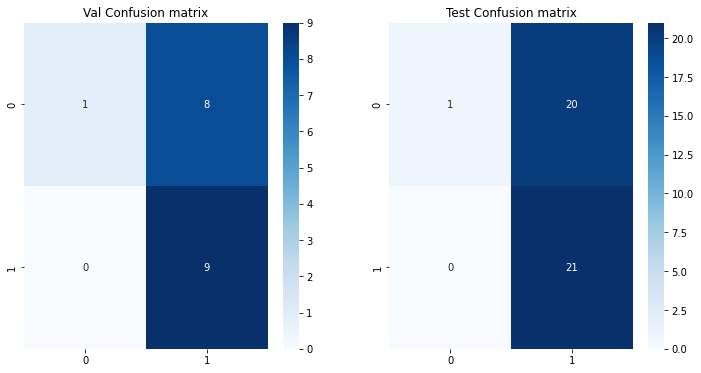

In [18]:
get_accuracy_metrics(model,  X_train, y_train, X_val, y_val, X_test, y_test)